## Category-1: Supervised Machine Learning on Structured Data

> There are 2 categories of problems - Regression(predict continuous variables), Classification (predict categories). This notebook shows an example of Classification

> Please note that this is just illustrative as to the steps to be taken to solve such problems. The focus is not getting the best possible performance.

> Dataset for this illustration is obtained from drivendata.org

> https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/ - Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Step 1: Load Libraries

In [1]:
# Step 1: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.simplefilter('ignore')
import bisect

from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy import stats

from sklearn.feature_selection import SelectFromModel

In [2]:
# Step 1.1: Functions to handle missing values
def num_missing(x):
  return sum(x.isnull())

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

### Step 2: Load Training data

In [3]:
# Step 2: Load Training dataset
train_features_filename = '../0.datasets/DD-WaterPump-Train-Features.csv'
train_labels_filename = '../0.datasets/DD-WaterPump-Train-Labels.csv'
train_features = pd.read_csv(train_features_filename, header=0,na_values='')
train_labels = pd.read_csv(train_labels_filename, header=0,na_values='')
train_df_original = pd.merge(train_features, train_labels, on='id',how='inner',sort=False)

In [4]:
train_df_original.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Step 3: Data Exploration

In [5]:
# Step 3: Data Exploration
# There are 41 columns - 1 Target (status_group), 1 id, 9 numerical and 30 categorical
# Univariate & Bivariate analysis of columns are done to select relevant variables. 
# Some examples are shown below

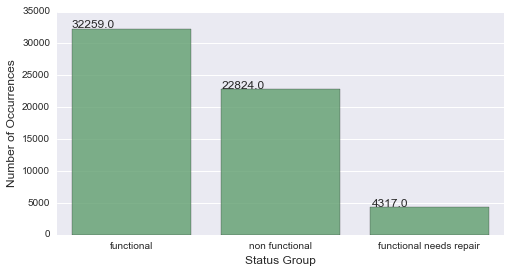

In [6]:
# Target Variable
status_group = train_df_original['status_group'].value_counts()

plt.figure(figsize=(8,4))
ax=sns.barplot(status_group.index, status_group.values, alpha=0.8, color=color[1])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.005))

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Status Group', fontsize=12)
plt.show()

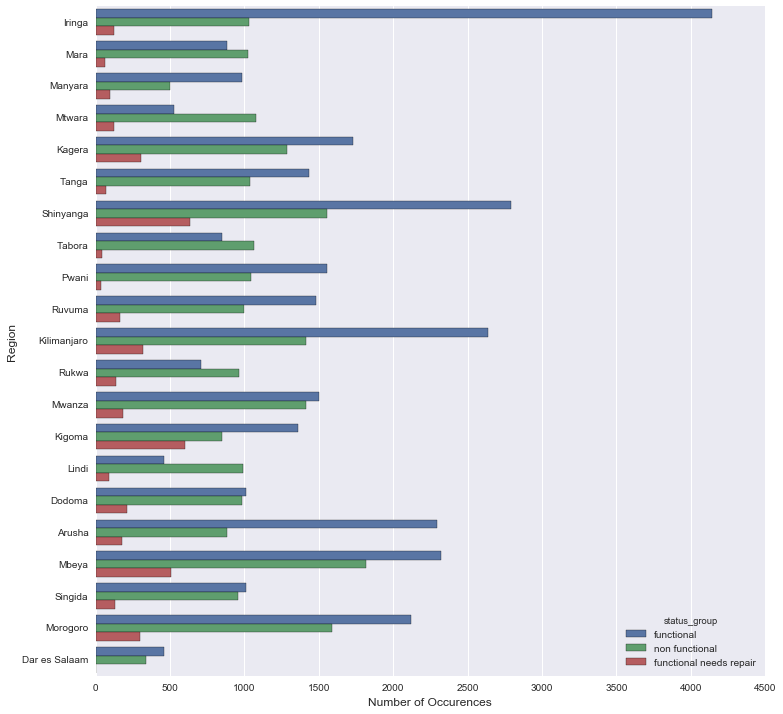

In [7]:
# Countplot of Region
# Using Region for countplot
plt.figure(figsize=(12,12))
sns.countplot(y='region', hue='status_group', data=train_df_original)
plt.ylabel('Region', fontsize=12)
plt.xlabel('Number of Occurences', fontsize=12)
plt.show()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64


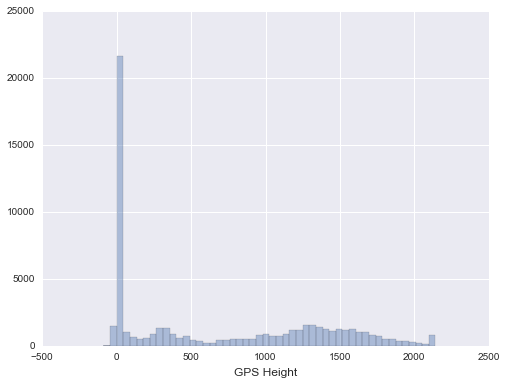

In [8]:
# GPS Height
print(train_df_original['gps_height'].describe())

ulimit = np.percentile(train_df_original.gps_height.values, 99)
train_df_original['gps_height'].ix[train_df_original['gps_height']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(train_df_original.gps_height.values, bins=50, kde=False)
plt.xlabel('GPS Height', fontsize=12)
plt.show()

** GPS Height signifies the altitude of the well. So it cannot be zero. Can be imputed with the median value **

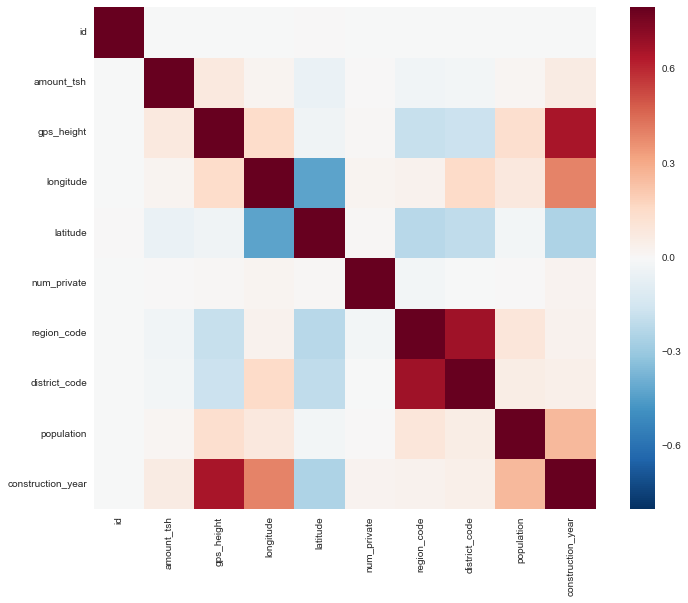

In [9]:
#correlation matrix
corrmat = train_df_original.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Data Exploration is a broad area on its own. Assuming that you have explored all the variables appropriately, the following variables are selected for further modeling

In [10]:
selected_col_list = ['gps_height','ward','lga','population','latitude','longitude','status_group']
train_df = train_df_original[selected_col_list]
train_df.head()

,gps_height,ward,lga,population,latitude,longitude,status_group
0,1390.0,Mundindi,Ludewa,109,-9.856322,34.938093,functional
1,1399.0,Natta,Serengeti,280,-2.147466,34.698766,functional
2,686.0,Ngorika,Simanjiro,250,-3.821329,37.460664,functional
3,263.0,Nanyumbu,Nanyumbu,58,-11.155298,38.486161,non functional
4,0.0,Nyakasimbi,Karagwe,0,-1.825359,31.130847,functional


### Step 4: Data Preprocessing

In [11]:
# Step 4: Data Preprocessing
# Replace 0 with NaN where 0 does not make sense
train_df[['gps_height','population']] = train_df[['gps_height','population']].replace(0, np.NaN)

In [12]:
#### Step 4.1: Outlier handling
# GPS Height - Altitude of the well
llimit_gps_height = np.nanpercentile(train_df.gps_height.values, 4)
ulimit_gps_height = np.nanpercentile(train_df.gps_height.values, 99)
train_df['gps_height'].ix[train_df['gps_height']<llimit_gps_height] = llimit_gps_height
train_df['gps_height'].ix[train_df['gps_height']>ulimit_gps_height] = ulimit_gps_height

# Population
ulimit_pop = np.nanpercentile(train_df.population.values, 99)
train_df['population'].ix[train_df['population']>ulimit_pop] = ulimit_pop

# Latitude & Longitude    
llimit = np.nanpercentile(train_df.latitude.values, 1)
ulimit = np.nanpercentile(train_df.latitude.values, 99)
train_df['latitude'].ix[train_df['latitude']<llimit] = llimit
train_df['latitude'].ix[train_df['latitude']>ulimit] = ulimit

llimit = np.nanpercentile(train_df.longitude.values, 1)
ulimit = np.nanpercentile(train_df.longitude.values, 99)
train_df['longitude'].ix[train_df['longitude']<llimit] = llimit
train_df['longitude'].ix[train_df['longitude']>ulimit] = ulimit

In [13]:
#### Step 4.2: Missing data handling
imputer_median = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
median_gps_height = imputer_median.fit(train_df[["gps_height"]])
median_population = imputer_median.fit(train_df[["population"]])
train_df["gps_height"]=median_gps_height.transform(train_df[["gps_height"]]).ravel()
train_df["population"]=median_population.transform(train_df[["population"]]).ravel()

missing_data = DataFrameImputer().fit(train_df)
train_df = missing_data.transform(train_df)

print (train_df.apply(num_missing, axis=0))

gps_height      0
ward            0
lga             0
population      0
latitude        0
longitude       0
status_group    0
dtype: int64


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 7 columns):
gps_height      59400 non-null float64
ward            59400 non-null object
lga             59400 non-null object
population      59400 non-null float64
latitude        59400 non-null float64
longitude       59400 non-null float64
status_group    59400 non-null object
dtypes: float64(4), object(3)
memory usage: 3.6+ MB


In [15]:
#### Step 4.3: Feature engineering / Variable creation
# Idea is to create new variables that best represent the signals from the input dataset for the modeling algorithm.
# Not illustrated for this example

#### Step 4.4: Drop unwanted columns
# If required, you can drop unwanted columns like id etc. at this stage

In [16]:
#### Step 4.5: Extract the target column
target_to_be_encoded = np.ravel(np.array(train_df['status_group'].values))
encoder = LabelEncoder()
encoder.fit(target_to_be_encoded)
print(encoder.classes_)
train_target = encoder.transform(target_to_be_encoded)
train_df = train_df.drop(['status_group'],axis=1)

['functional' 'functional needs repair' 'non functional']


In [17]:
#### Step 4.6: Variable Transformation
## An important step that transforms the variables as appropriate

# Variable transformation - Split columns by type
float_columns=[]
cat_columns=[]
int_columns=[]
    
for i in train_df.columns:
    if train_df[i].dtype == 'float': 
        float_columns.append(i)
    elif train_df[i].dtype == 'object' or train_df[i].dtype == 'bool':
        cat_columns.append(i)
    elif train_df[i].dtype == 'int64':
        int_columns.append(i)
          
train_cat_features = train_df[cat_columns]
train_float_features = train_df[float_columns]
train_int_features = train_df[int_columns]

# Transformation for Categorical variables
cat_transform_dict = {'ward':['le','le_ward'],  # Label encoding for ward
                      'lga':['le','le_lga']     # Label encoding for lga
                     }

fitted_cat_objects_list = []
for i in train_cat_features.columns:
    original_values = train_cat_features[i].values.copy()
    transform = cat_transform_dict[i][0]
    transform_name = cat_transform_dict[i][1]
    X_temp = train_cat_features[i].values.reshape(-1,1)
    if transform == 'le':            # Label Encoding  
        transform_name = LabelEncoder().fit(X_temp)
        train_cat_features.loc[:,i] = transform_name.transform(X_temp)
        fitted_cat_objects_list.append(transform_name)
    if transform == 'oh':            # One Hot Encoding  
        one_hot = pd.get_dummies(train_cat_features[i],prefix=i,drop_first=True)
        train_cat_features = train_cat_features.drop(i,axis=1)
        train_cat_features = train_cat_features.join(one_hot)
        fitted_cat_objects_list.append("One Hot Encoding")

new_cat_columns=[]
for i in train_cat_features.columns:
    new_cat_columns. append(i)
    
# Transformation of Float Columns
float_transform_dict = {'gps_height':['scaler','scaler_gps_height'],
                        'population':['scaler','scaler_population'],
                        'latitude': ['none','none_latitude'],
                        'longitude': ['none','none_longitude']
                        } 
fitted_float_objects_list = []

for i in train_float_features.columns:
    original_values = train_float_features[i].values.copy()
    transform = float_transform_dict[i][0]
    transform_name = float_transform_dict[i][1]
    X_temp = train_float_features[i].values.reshape(-1,1)
    skew_ = stats.skew(X_temp)
    if transform == 'scaler':            # Rescale data (between 0 and 1)   
        transform_name = MinMaxScaler(feature_range=(0, 1)).fit(X_temp)
        train_float_features.loc[:,i] = transform_name.transform(X_temp)
        fitted_float_objects_list.append(transform_name)
    elif transform == 'standardizer':    # Standardize data (0 mean, 1 stdev)
        transform_name = StandardScaler().fit(X_temp) 
        train_float_features.loc[:,i] = transform_name.transform(X_temp)
        fitted_float_objects_list.append(transform_name)
    elif transform == 'normalizer':     # Normalize data (length of 1)
        transform_name = Normalizer().fit(X_temp) 
        train_float_features.loc[:,i] = transform_name.transform(X_temp)
        fitted_float_objects_list.append(transform_name)
    elif transform == 'log10':
        train_float_features.loc[:,i] = np.log10(X_temp+1)
    elif transform == 'boxcox':  # or if abs(skew_) > 0.25
        train_float_features.loc[:,i],lam = stats.boxcox(X_temp)  #BoxCox transform. Might have to add 1 to make it non-zero
        #train_float_features.loc[:,i] = boxcox(1+X_temp[:,2])[0]  # Use this only if the above one does not work
        print('Lambda: %f' %lam)
       
        print(fitted_float_objects_list)
        
# Creating the final train_transformed_features dataset
train_transformed_features = np.concatenate((train_cat_features,train_float_features,
                                             train_int_features),axis=1)
train_transformed_features = pd.DataFrame(data=train_transformed_features)

## Assign column names
all_cols = new_cat_columns + float_columns + int_columns
train_transformed_features.columns = all_cols

In [18]:
train_transformed_features.head()

,ward,lga,gps_height,population,latitude,longitude
0,1426.0,51.0,0.648434,0.043217,-9.856322,34.938093
1,1576.0,103.0,0.652641,0.111645,-2.147466,34.698766
2,1624.0,108.0,0.319308,0.099640,-3.821329,37.460664
3,1571.0,87.0,0.121552,0.022809,-11.112547,38.486161
4,1687.0,26.0,0.068724,0.059624,-1.825359,31.130847


In [19]:
X_for_feature_selection = train_transformed_features
Y_for_feature_selection = train_target

In [20]:
Y_for_feature_selection

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Step 5: Feature Selection

In [21]:
#### Step 5: Feature Selection
## This step selects the variables to be taken to the modeling step. 
## Code below illustrates a couple of feature selection methods out of many possible ones

features_df_algos = pd.DataFrame()
feature_cols = pd.Series(train_df.columns)

feature_selection = ['ExtraTrees','RFE']
num_features_to_be_selected = 4

#### Feature Selection 1: ExtraTrees
if 'ExtraTrees' in feature_selection:
    from sklearn.ensemble import ExtraTreesClassifier
    feature_selection_model_et = ExtraTreesClassifier()  # To be used in Classification problems
    # feature_selection_model_et = ExtraTreesRegressor() # To be used in Regression problems
    feature_selection_model_et.fit(X_for_feature_selection, Y_for_feature_selection)
    
    # Feature Importance values
    feature_imp_et=pd.Series(feature_selection_model_et.feature_importances_, index=feature_cols)
    feature_imp_et = pd.DataFrame(feature_imp_et).reset_index()
    feature_imp_et.columns = ['Features', 'Values_et']
    
    # Selecting from model
    model_feature_selection_et = SelectFromModel(feature_selection_model_et, prefit=True, threshold=0.05)
    features_selected_et = model_feature_selection_et.transform(X_for_feature_selection)
    n_features = features_selected_et.shape[1]
   
    while n_features > num_features_to_be_selected:
        model_feature_selection_et.threshold += 0.01
        features_selected_et = model_feature_selection_et.transform(X_for_feature_selection)
        n_features = features_selected_et.shape[1]
    
    temp_features_df = pd.DataFrame(X_for_feature_selection.columns[model_feature_selection_et.get_support()])
    temp_features_df.columns = ['ET']
    features_df_algos = pd.concat([features_df_algos,temp_features_df],axis=1)
    
# Feature Selection 2: RFE - Recursive Feature Elimination
if 'RFE' in feature_selection:
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    
    model = LogisticRegression() # To be used in Classification problems
    #model = LinearRegression() # To be used in Regression problems
    rfe = RFE(model, num_features_to_be_selected) # second parameter - number of features to be selected
    fit_rfe = rfe.fit(X_for_feature_selection, Y_for_feature_selection)
    
    #print("Num Features: ",fit_rfe.n_features_)
    #print("Selected Features: ",fit_rfe.support_)
    #print("Feature Ranking: ",fit_rfe.ranking_)
    features_selected_rfe = fit_rfe.transform(X_for_feature_selection)
    
    temp_features_df = pd.DataFrame(X_for_feature_selection.columns[fit_rfe.support_])
    temp_features_df.columns = ['RFE']
    features_df_algos = pd.concat([features_df_algos,temp_features_df],axis=1)

In [22]:
features_df_algos

,ET,RFE
0,gps_height,gps_height
1,population,population
2,latitude,latitude
3,longitude,longitude


** Based on feature selection using 2 methods, the 4 important variables are: gps_height, population, latitude & longitude **

In [23]:
selected_cols=['gps_height','population','latitude','longitude','lga']
selected_X = X_for_feature_selection[selected_cols]

X = selected_X
Y = train_target

# X & Y are the final variables taken for modeling

### Step 6: Compare Algorithms 

In [24]:
#### Step 6: Compare Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn import cross_validation
from sklearn.metrics import accuracy_score,log_loss

# Demonstrating the use of 3 algorithms. More can be added as required
models_to_compare = ['LR','CART','XGB']

C:\Users\Karthikeyan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
#### 6.1: Choose Evaluation Metric
scoring = 'accuracy'
#scoring = 'roc_auc'
#scoring = "f1_macro"
#scoring = 'neg_log_loss'

#### Step 6.2: Set Cross-Validation parameters
# Step 6.2.1: Evaluate using K-fold Cross Validation
n_splits = 10
num_instances = len(X)
seed = 10

In [26]:
#### 6.3: Build the models list
models = []

if 'LR' in models_to_compare:
    models.append(('LR', LogisticRegression()))
    
if 'CART' in models_to_compare:
    models.append(('CART', DecisionTreeClassifier()))

if 'XGB' in models_to_compare:
    models.append(('XGB', XGBClassifier()))

LR: 0.538013 (0.006615)
CART: 0.644327 (0.003697)
XGB: 0.622559 (0.010107)


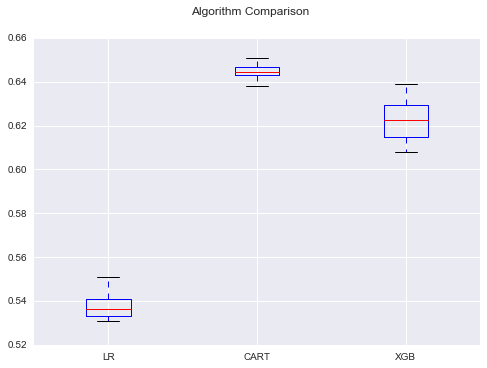

In [27]:
#### 6.4: Run k-fold validation on models and visualize the results
results = []
names = []
for name, model in models:
    # Choosing kfold cross-validation in this case
    kfold = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    #kfold = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Visualize Results for Classification
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [28]:
#### 6.5: Select the models for further tuning
algos_selected_for_tuning = ['XGB']

### Step 7: Hyper-parameter tuning

In [29]:
#### Step 7.1: Creating the param grid & the model
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
import time

models_to_tune = []
param_grid_to_tune = []

if 'LR' in algos_selected_for_tuning:  #1. Logistic Regression
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    penalty = ['l1','l2']
    #param_grid_lr = {'C':[100, 1000], 'tol': [0.001, 0.0001]}
    param_grid_lr = dict(C=c_values, penalty=penalty)
    
    model_lr = LogisticRegression()
    models_to_tune.append(model_lr)
    param_grid_to_tune.append(param_grid_lr)
    #model_1r = LogisticRegression(solver='lbfgs', multi_class='multinomial')

if 'XGB' in algos_selected_for_tuning:  #2. XGB
    n_estimators = [50,100]
    max_depth = [2,4]
    learning_rate = [0.01, 0.1]
    param_grid_xgb = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)
    
    model_xgb = XGBClassifier()
    models_to_tune.append(model_xgb)
    param_grid_to_tune.append(param_grid_xgb)

C:\Users\Karthikeyan\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [30]:
#### Step 7.2: Choose Search strategy
#search = "random_search"
search = "grid_search"

##### Step 7.3: Tuning the model(s)
for i in range(0,len(models_to_tune)):
    model_to_tune = models_to_tune[i]
    param_grid = param_grid_to_tune[i]
    print("Algorithm: ",algos_selected_for_tuning[i])
    print(model_to_tune.get_params())
    kfold = cross_validation.KFold(n=num_instances, n_folds=n_splits, random_state=seed)
    if search == "grid_search":
        ## Grid Search
        print("[INFO] tuning hyperparameters via grid search")
        grid = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, scoring=scoring, cv=kfold)
    elif search == "random_search":
        ## Random Search
        print("[INFO] tuning hyperparameters via random search")
        grid = RandomizedSearchCV(estimator=model_to_tune, param_distributions=param_grid, scoring=scoring, cv=kfold)
       
    start = time.time()
    grid_result = grid.fit(X, Y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    for params, mean_score, scores in grid_result.grid_scores_:
        print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    print("[INFO] search took {:.2f} seconds".format(time.time() - start))

Algorithm:  XGB
{'n_estimators': 100, 'max_depth': 3, 'silent': True, 'learning_rate': 0.1, 'colsample_bytree': 1, 'base_score': 0.5, 'missing': None, 'min_child_weight': 1, 'objective': 'binary:logistic', 'gamma': 0, 'max_delta_step': 0, 'reg_lambda': 1, 'seed': 0, 'nthread': -1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_alpha': 0, 'scale_pos_weight': 1}
[INFO] tuning hyperparameters via grid search
Best: 0.635808 using {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
0.561835 (0.005921) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01}
0.562424 (0.006315) with: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01}
0.585539 (0.006919) with: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.01}
0.589680 (0.007017) with: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01}
0.589630 (0.005348) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
0.602323 (0.006515) with: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 

In [31]:
#### Step 7.4: Compute final cross-validation metric values
algos_selected_after_tuning = ['XGB']

test_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
eval_set = [(X_train, Y_train), (X_validation, Y_validation)]

models_after_tuning = []

for i in range(0,len(algos_selected_after_tuning)):
    algo = algos_selected_after_tuning[i]
    if algo=='XGB':
        model_xgb = XGBClassifier(n_estimators=100,max_depth=4,learning_rate=0.1)
        model_xgb.fit(X, Y)
        models_after_tuning.append(model_xgb)
        
    if algo=='LR':
        model_lr = LogisticRegression(C=1, penalty='l1')
        model_lr.fit(X, Y)
        models_after_tuning.append(model_lr)

In [32]:
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report

for i in range(0,len(models_after_tuning)):
    model_for_cv = models_after_tuning[i]
    
    if model_for_cv == "model_xgb":
    #Use error & logloss for binary classification & merror & mlogloss for multiclass classification
        model_for_cv.fit(X_train, Y_train, early_stopping_rounds=10,eval_metric=["error","logloss"], eval_set=eval_set, verbose=True)
    # If Regression use rmse and mae
        #model_for_cv.fit(X_train, Y_train, eval_metric=["rmse","mae"], eval_set=eval_set, verbose=True)
    else:
        model_for_cv.fit(X_train, Y_train)
    
    print("Metrics for Algorithm: ",model_for_cv)
    y_pred = model_for_cv.predict(X_validation)
    predictions = [round(value) for value in y_pred]
    accuracy_1 = accuracy_score(Y_validation, predictions)
    print("Accuracy of Algorithm 3: %.2f%%" % (accuracy_1 * 100.0))
    print(confusion_matrix(Y_validation, y_pred))
    print(classification_report(Y_validation, y_pred))

Metrics for Algorithm:  XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Accuracy of Algorithm 3: 63.55%
[[5365   31 1022]
 [ 632   48  196]
 [2438   11 2137]]
             precision    recall  f1-score   support

          0       0.64      0.84      0.72      6418
          1       0.53      0.05      0.10       876
          2       0.64      0.47      0.54      4586

avg / total       0.63      0.64      0.61     11880



In [33]:
#### Step 7.5: Create the final model(s) using the full training set and best hyper-parameters

final_models = []

for i in range(0,len(algos_selected_after_tuning)):
    algo = algos_selected_after_tuning[i]
    if algo=='XGB':
        model_xgb = XGBClassifier(n_estimators=100,max_depth=4,learning_rate=0.1)
        model_xgb.fit(X, Y)
        final_models.append(model_xgb)
        
    if algo=='LR':
        model_lr = LogisticRegression(C=1, penalty='l1')
        model_lr.fit(X, Y)
        final_models.append(model_lr)

### Step 8: Predict on Test Set

In [34]:
#### Step 8.1: Load the test set
test_filename = '../0.datasets/DD-WaterPump-Test.csv' 
test_df_original = pd.read_csv(test_filename, header=0,na_values='')

In [35]:
#### Step 8.2: Data pre-processing
selected_col_list_test = ['gps_height','ward','lga','population','latitude','longitude']
test_df = test_df_original[selected_col_list_test]

In [36]:
# Replace 0 with NaN where 0 does not make sense
test_df[['gps_height','population']] = test_df[['gps_height','population']].replace(0, np.NaN)
#### Outlier handling
# GPS Height - Altitude of the well
test_df['gps_height'].ix[test_df['gps_height']<llimit_gps_height] = llimit_gps_height
test_df['gps_height'].ix[test_df['gps_height']>ulimit_gps_height] = ulimit_gps_height

# Population
test_df['population'].ix[test_df['population']>ulimit_pop] = ulimit_pop

#print (test_df.apply(num_missing, axis=0))
test_df["gps_height"]=median_gps_height.transform(test_df[["gps_height"]]).ravel()
test_df["population"]=median_population.transform(test_df[["population"]]).ravel()

test_df = missing_data.transform(test_df)
#print (test_df.apply(num_missing, axis=0))   

In [37]:
# Variable Transformation of Feature columns
test_float_columns=[]
test_cat_columns=[]
test_int_columns=[]

for i in test_df.columns:
    if test_df[i].dtype == 'float': 
        test_float_columns.append(i)
    elif test_df[i].dtype == 'object' or test_df[i].dtype == 'bool' :
        test_cat_columns.append(i)
    elif test_df[i].dtype == 'int64':
        test_int_columns.append(i)

test_cat_features = test_df[test_cat_columns]
test_float_features = test_df[test_float_columns]
test_int_features = test_df[test_int_columns]

count = 0
for i in test_cat_features.columns:
    X_temp_test = test_cat_features[i].values.reshape(-1,1)
    transform = cat_transform_dict[i][0]

    if transform == 'le':            # Label Encoding - IMPORTANT: Code below to handle new classes not seen in training set
        fitted_object = fitted_cat_objects_list[count]
        print("Fitted object ",fitted_object)
        X_temp_test = test_cat_features.loc[:,i].map(lambda s:'other' if s not in fitted_object.classes_ else s)
        temp_classes = fitted_object.classes_.tolist()
        bisect.insort_left(temp_classes,'other')
        fitted_object.classes_ = temp_classes
        test_cat_features.loc[:,i] = fitted_object.transform(X_temp_test)
        count = count + 1
    if transform == 'oh':
        fitted_object = fitted_cat_objects_list[count]
        print("Fitted object ",fitted_object)
        one_hot_test = pd.get_dummies(test_cat_features[i],prefix=i,drop_first=True)
        test_cat_features = test_cat_features.drop(i,axis=1)
        test_cat_features = test_cat_features.join(one_hot_test)        
        count = count + 1 

new_test_cat_columns=[]
for i in test_cat_features.columns:
    new_test_cat_columns. append(i)
    
    count = 0

for i in test_float_features.columns:
    X_temp_test = test_float_features[i].values.reshape(-1,1)
    transform = float_transform_dict[i][0]
    if transform == 'scaler' or transform == 'standardizer' or transform == 'normalizer':
        fitted_object = fitted_float_objects_list[count]
        print("Fitted object ",fitted_object)
        test_float_features.loc[:,i] = fitted_object.transform(X_temp_test)
        count = count + 1
    elif transform == 'log10':
        test_float_features.loc[:,i] = np.log10(X_temp_test) 

# Creating the final test_transformed_features dataset
temp_1 = np.concatenate((test_cat_features,test_float_features),axis=1)
test_transformed_features = np.concatenate((temp_1,test_int_features),axis=1)
test_transformed_features = pd.DataFrame(data=test_transformed_features)

## Assign column names
all_cols_test = new_test_cat_columns + test_float_columns + test_int_columns
test_transformed_features.columns = all_cols_test

Fitted object  LabelEncoder()
Fitted object  LabelEncoder()
Fitted object  MinMaxScaler(copy=True, feature_range=(0, 1))
Fitted object  MinMaxScaler(copy=True, feature_range=(0, 1))


In [38]:
test_transformed_features.head()

,ward,lga,gps_height,population,latitude,longitude
0,18.0,63.0,0.931744,0.128051,-4.059696,35.290799
1,691.0,0.0,0.732118,0.119648,-3.309214,36.656709
2,1787.0,109.0,0.731183,0.199680,-5.004344,34.767863
3,1280.0,49.0,0.123422,0.099640,-9.418672,38.058046
4,1155.0,61.0,0.587658,0.023609,-10.950412,35.006123


In [39]:
X_test_for_feature_selection = test_transformed_features
selected_X_test = X_test_for_feature_selection[selected_cols]
X_test = selected_X_test

In [40]:
predictions = pd.DataFrame()
for i in range(0,len(final_models)):
    algo = algos_selected_after_tuning[i]
    loaded_model = final_models[i]
    print(loaded_model)
    predictions[i] = loaded_model.predict(X_test)
    #print(predictions[i])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [41]:
final_df = pd.DataFrame()
final_df[['id']] = test_df_original[['id']]
final_df['status_class'] = 0
final_df['status_group'] = 'functional'

final_df['status_class'] = predictions[0]  #Predictions from XGBoost
final_df.loc[final_df.status_class == 0,'status_group'] = 'functional'
final_df.loc[final_df.status_class == 1,'status_group'] = 'functional needs repair'
final_df.loc[final_df.status_class == 2,'status_group'] = 'non functional'

print(final_df.groupby('status_group').size())

final_df.head(25)

status_group
functional                 10611
functional needs repair      115
non functional              4124
dtype: int64


,id,status_class,status_group
0,50785,0,functional
1,51630,0,functional
2,17168,0,functional
3,45559,2,non functional
4,49871,0,functional
5,52449,0,functional
6,24806,0,functional
7,28965,2,non functional
8,36301,2,non functional
9,54122,0,functional
